In [1]:
import os
import WiSe 
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import data_cleaning as dc
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, auc, roc_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.metrics import mean_squared_error, auc, roc_curve, accuracy_score, roc_auc_score, r2_score, confusion_matrix

# TabNet Predictions

In [11]:
# load the dataset
df = pd.read_csv("telco_data.csv")
target = 'Churn'
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)
df['Churn'] = df['Churn'].apply(lambda x: 0 if x == "No" else 1)
df = df.drop(columns=['customerID'])

In [8]:
def print_kpi(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_pred, y_test)))
    fpr, tpr, _ = roc_curve(y_test,model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Area = {:.5f}".format(auc(fpr, tpr)));
    return;

In [30]:
def tabnet_train(features, max_epochs=50, lr=0.01, lambda_sparse=1e-5, step_size=75, gamma=0.7, verbose=1):
    # load the dataset
    df = pd.read_csv("telco_data.csv")
    target = 'Churn'
    df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)
    df['Churn'] = df['Churn'].apply(lambda x: 0 if x == "No" else 1)
    df = df.drop(columns=['customerID'])

    # Split features and target
    X = df.drop(columns="Churn")[features]
    y = df['Churn']

    # ordinal encoding & compute col_idx & cold_dim
    cat_idxs = []
    cat_dims = []
    for idx, col in enumerate(X.columns):
        if df[col].dtype == object: 
            X, mapping = dc.feature_ordinalEncoding(X, col)
            cat_idxs.append(idx)
            cat_dims.append(len(mapping))

    # split train, validation, test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

    # convert to numpy array
    X_train = X_train.values
    X_test = X_test.values
    X_valid = X_valid.values
    y_train = y_train.values
    y_test = y_test.values
    y_valid = y_valid.values
    
    model = TabNetClassifier(
                           n_d=15, n_a=15,
                           cat_idxs=cat_idxs,
                           cat_dims=cat_dims,
                           cat_emb_dim=1,
                           optimizer_fn=torch.optim.Adam,
                           optimizer_params=dict(lr=lr),
                           lambda_sparse=lambda_sparse,
                           n_steps=7,
                           scheduler_params={"step_size":75, # how to use learning rate scheduler
                                             "gamma":0.7},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           mask_type='sparsemax',
                           verbose=verbose)
    
    model.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs,
        patience=300,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        drop_last=False, 
        #weights=weights
    )
    
    
    print_kpi(model, X_test, y_test)
    return model, X_train,  y_train 

In [10]:
def print_feature_importance(tabnet_model, features, nbr_features_to_print=10):
    dict_feature_importance = dict(zip(features, tabnet_model.feature_importances_))
    dict_feature_importance = {k: v for k, v in sorted(dict_feature_importance.items(), key=lambda item: item[1], reverse=True)}

    fig, ax = plt.subplots()

    y_pos = np.arange(len(features))

    ax.barh(y_pos[:nbr_features_to_print], list(dict_feature_importance.values())[:nbr_features_to_print], align='center')
    ax.set_yticks(y_pos[:nbr_features_to_print])
    ax.set_yticklabels(list(dict_feature_importance.keys())[:nbr_features_to_print])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Relative Importance in the Descision')
    ax.set_title('Feature Importance')
    plt.show()

## I. TabNet on Full Dataset

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_valid_auc = 0.83146
Best weights from best epoch are automatically used!
Accuracy: 0.79


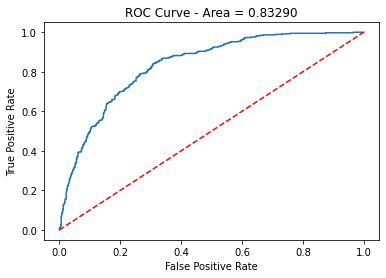

In [16]:
# train on full dataset
model_full, X_test_full, y_test_full = tabnet_train(df.drop(columns='Churn').columns, 
                                                    max_epochs=200, verbose=0)

## II. TabNet on WiSe Selection

In [2]:
# load the dataset
df = pd.read_csv("telco_data.csv")
target = 'Churn'
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)
df['Churn'] = df['Churn'].apply(lambda x: 0 if x == "No" else 1)
df = df.drop(columns=['customerID'])
target = 'Churn'

# convert dataframe
for col in df.columns:
    if df[col].dtype == object: 
        df, _ = dc.feature_ordinalEncoding(df, col)

In [3]:
# apply univariate selection filters 
selected_pearson = WiSe.univariate_filter_spearman(df, target)
selected_spearman = WiSe.univariate_filter_spearman(df, target)
selected_univariate = list(set.union(set(selected_pearson), set(selected_spearman)))

In [6]:
# apply model selection based filtering 
selected_lasso = WiSe.model_selection_lasso(df.sample(1000), target, selected_univariate)
print("Remaining number of features: ", len(selected_lasso), "out of", df.shape[1] -1)

Remaining number of features:  15 out of 19



Early stopping occurred at epoch 95 with best_epoch = 45 and best_valid_auc = 0.824
Best weights from best epoch are automatically used!
Accuracy: 0.79


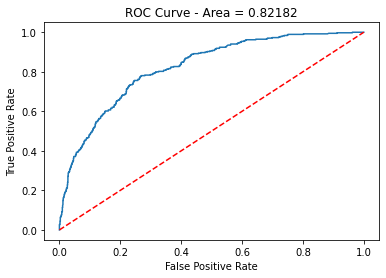

In [155]:
model_WiSe, X_test_WiSe, y_test_WiSe = tabnet_train(selected_univariate, 
                                                    max_epochs=500, verbose=0)

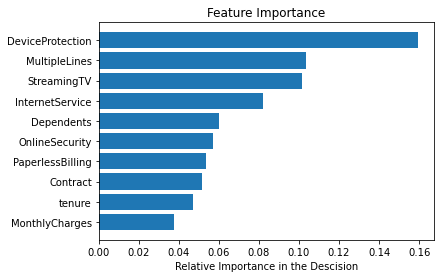

In [156]:
print_feature_importance(model_WiSe, selected_lasso, 10)

**Remark:** Performance are poor. WiSe selection removed 75% of the features when at least a subset of 50% relevant features would give an appropriate model.   
Some finer hyper-parameters tunnning is necessary. 


Early stopping occurred at epoch 119 with best_epoch = 69 and best_valid_auc = 0.8144
Best weights from best epoch are automatically used!
Accuracy: 0.78


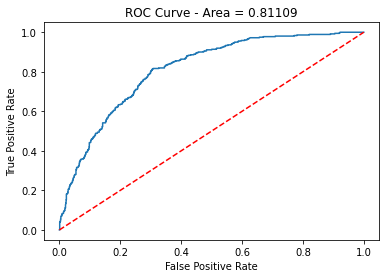

In [32]:
model_WiSe, X_test_WiSe, y_test_WiSe = tabnet_train(selected_univariate, 
                                                    lr=0.1, lambda_sparse=5e-4, 
                                                    step_size=100, gamma=0.07,
                                                    max_epochs=250, verbose=0)

## TabNet on RFE Selection

In [3]:
# load the dataset
df = pd.read_csv("telco_data.csv")
target = 'Churn'
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)
df['Churn'] = df['Churn'].apply(lambda x: 0 if x == "No" else 1)
df = df.drop(columns=['customerID'])
target = 'Churn'

# convert dataframe
for col in df.columns:
    if df[col].dtype == object: 
        df, _ = dc.feature_ordinalEncoding(df, col)

In [6]:
df_reduced = df.sample(1000)

In [7]:
selected_rfe_15 = WiSe.model_selection_RFE(df_reduced, target, df_reduced.drop(columns=[target]).columns, 15)

In [8]:
selected_rfe_10 = WiSe.model_selection_RFE(df_reduced, target, df_reduced.drop(columns=[target]).columns, 10)

In [21]:
selected_rfe_10

Index(['gender', 'SeniorCitizen', 'PhoneService', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

Stop training because you reached max_epochs = 50 with best_epoch = 44 and best_valid_auc = 0.83322
Best weights from best epoch are automatically used!
Accuracy: 0.78


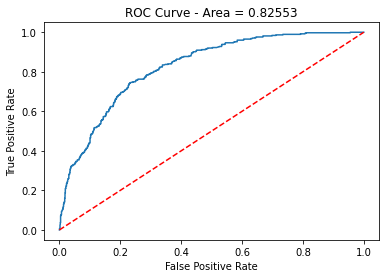

In [14]:
model_rfe15, X_test_rfe15, y_test_rfe15 = tabnet_train(selected_rfe_15, 
                                                    max_epochs=50, verbose=0)

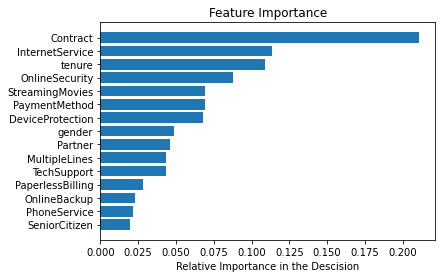

In [19]:
print_feature_importance(model_rfe15, selected_rfe_15, 15)

Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_valid_auc = 0.77549
Best weights from best epoch are automatically used!
Accuracy: 0.76


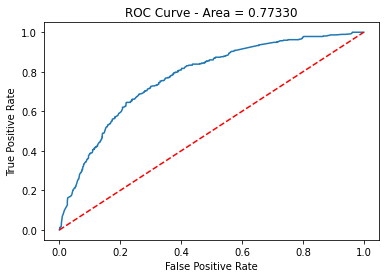

In [15]:
model_rfe10, X_test_rfe10, y_test_rfe10 = tabnet_train(selected_rfe_10, 
                                                    max_epochs=50, verbose=0)

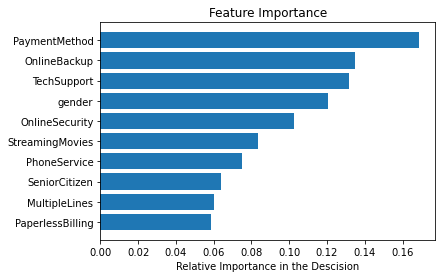

In [22]:
print_feature_importance(model_rfe10, selected_rfe_10, 10)

**Remark:** Results aren't conclusive. For instance, gender is considered as a significant predictor of churn likelihood, whereas, it should not. 

## II. Create TabNet "Trainer"

In [150]:
import torch
import numpy as np
import pandas as pd
import data_cleaning as dc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import mean_absolute_error, auc, roc_curve, accuracy_score, matthews_corrcoef, f1_score 

# target should already be encoded with O or 1
class TabNet_binary_classifer_model:
    def __init__(self, df, target, n_d=15, n_a=15, lr=1e-1, lambda_sparse=1e-5, step_size=75, gamma=0.7):
        # save values params
        self.n_d = n_d
        self.n_a = n_a
        self.lr = lr
        self.lambda_sparse = lambda_sparse
        self.step_size = step_size
        self.gamma = gamma
        
        # ordinal encoding 
        df, self.mappings, self.cat_dims_full = self.data_encoding(df)
        X, y = df.drop(columns=[target]), df[target]

        # split train, validation, test set
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2)
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(self.X_train, self.y_train, test_size=0.2)
        
        # original column ordering 
        self.original_ordering = np.array(self.X_train.columns)
        self.categorical_features = list(self.mappings.keys())
        
        # initialy, no assumption on features on which model should be trained 
        self.features = self.X_train.columns
        self.all_features = self.X_train.columns
        
        # convert to numpy array
        self.X_train = self.X_train.values
        self.X_test = self.X_test.values
        self.X_valid = self.X_valid.values
        self.y_train = self.y_train.values
        self.y_test = self.y_test.values
        self.y_valid = self.y_valid.values
        
        # model initialize later because requires categorical encodings  
        self.model = None
        self.cat_idxs = None
        self.cat_dims = None
        
    def print_kpi(self, selection_mask):
        y_pred = self.model.predict(self.X_test[:,selection_mask])
        # plot some relevant KPI
        print('Accuracy: {:.2f}'.format(accuracy_score(y_pred, self.y_test)))
        print('MCC Score: {:.2f}'.format(matthews_corrcoef(self.y_test, y_pred)))
        print('F1 Score: {:.2f}'.format(f1_score(self.y_test, y_pred)))

        # plot ROC curve 
        fpr, tpr, _ = roc_curve(self.y_test, self.model.predict_proba(self.X_test[:,selection_mask])[:,1])
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve - Area = {:.5f}".format(auc(fpr, tpr)));
    
        
    def reinitialize_model(self, cat_idxs, cat_dims):
        self.model = TabNetClassifier(
                           n_d=self.n_d, n_a=self.n_a,
                           cat_idxs=cat_idxs,
                           cat_dims=cat_dims,
                           cat_emb_dim=1,
                           optimizer_fn=torch.optim.Adam,
                           optimizer_params=dict(lr=sel.lr),
                           lambda_sparse=self.lambda_sparse,
                           n_steps=7,
                           scheduler_params={"step_size":self.step_size, # how to use learning rate scheduler
                                             "gamma":self.gamma},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           mask_type='sparsemax',
                           verbose=verbose)
        
        
        
    def data_encoding(self, df): 
        mappings = {}
        cat_dims_full = {}
        for col in dc.non_numerical_features(df):
            df, mapping = dc.feature_ordinalEncoding(df, col)
            mappings[col] = mapping
            cat_dims_full[col] = len(mapping)
            
        return df, mappings, cat_dims_full
    
    def get_cat_idxs(self, selected_features):  
        ordered_selected_features = [col for col in self.all_features if col in selected_features]
    
        cat_idxs = [idx for idx, col in enumerate(ordered_selected_features) if col in selected_features and col in self.categorical_features]
                
        cat_dims = [self.cat_dims_full[col] for col in ordered_selected_features if col in self.categorical_features]
        
        return cat_idxs, cat_dims, mask_selected
    
    def get_selection_mask(self, selected_features):
        is_selected = lambda x, list_: True if x in list_ else False
        selection_mask = [is_selected(col, selected_features) for col in self.all_features]
        return selection_mask
    
    
    def train_model(self, max_epochs=50, patience=50, reinitialize_model=False, features=None, 
                    eval_metric=['auc'], verbose=0, end_evaluation=False):
        if features == None:
            features = self.all_features
        
        self.features = features
            
        if self.model == None or reinitialize_model:
            cat_idxs, cat_dims, mask_selected = self.get_cat_idxs(features)
            self.model = TabNetClassifier(
                                   n_d=self.n_d, n_a=self.n_a,
                                   cat_idxs=cat_idxs,
                                   cat_dims=cat_dims,
                                   cat_emb_dim=1,
                                   optimizer_fn=torch.optim.Adam,
                                   optimizer_params=dict(lr=self.lr),
                                   lambda_sparse=self.lambda_sparse,
                                   n_steps=7,
                                   scheduler_params={"step_size":self.step_size, # how to use learning rate scheduler
                                                     "gamma":self.gamma},
                                   scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                   mask_type='sparsemax',
                                   verbose=verbose)
    
        selection_mask = self.get_selection_mask(features)
        
        self.model.fit(
            X_train=self.X_train[:,selection_mask], y_train=self.y_train,
            eval_set=[(self.X_train[:,selection_mask], self.y_train), (self.X_valid[:,selection_mask], self.y_valid)],
            eval_name=['train', 'valid'],
            eval_metric=eval_metric,
            max_epochs=max_epochs,
            patience=patience,
            batch_size=1024, virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            #weights=weights
        )
        
        if end_evaluation:
            self.print_kpi(selection_mask)
    
    def print_feature_importance(self, nbr_features_to_print=10):
        dict_feature_importance = dict(zip(self.features, self.model.feature_importances_))
        dict_feature_importance = {k: v for k, v in sorted(dict_feature_importance.items(), key=lambda item: item[1], reverse=True)}

        fig, ax = plt.subplots()

        y_pos = np.arange(len(self.features))

        ax.barh(y_pos[:nbr_features_to_print], list(dict_feature_importance.values())[:nbr_features_to_print], align='center')
        ax.set_yticks(y_pos[:nbr_features_to_print])
        ax.set_yticklabels(list(dict_feature_importance.keys())[:nbr_features_to_print])
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Relative Importance in the Descision')
        ax.set_title('Feature Importance')
        plt.show()
    
        return 
        
        
        

Stop training because you reached max_epochs = 100 with best_epoch = 86 and best_valid_auc = 0.84441
Best weights from best epoch are automatically used!
Accuracy: 0.81
MCC Score: 0.48
F1 Score: 0.59


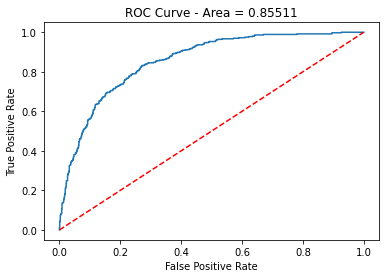

In [153]:
df = pd.read_csv("telco_data.csv")
target = 'Churn'
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)
df['Churn'] = df['Churn'].apply(lambda x: 0 if x == "No" else 1)
df = df.drop(columns=['customerID'])

TabNet = TabNet_binary_classifer_model(df, 'Churn')
TabNet.train_model(max_epochs=100, verbose=0, end_evaluation=True)

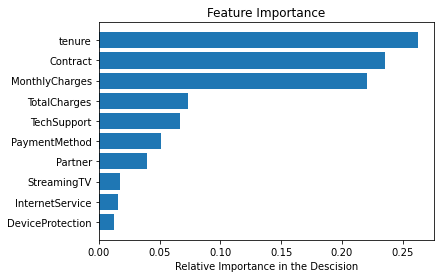

In [154]:
TabNet.print_feature_importance()

In [69]:
TabNetClassifier?

In [33]:
df = pd.read_csv("telco_data.csv")
target = 'Churn'
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)
df['Churn'] = df['Churn'].apply(lambda x: 0 if x == "No" else 1)
df = df.drop(columns=['customerID'])

In [89]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [90]:
selected_features = ['PaymentMethod', 'StreamingTV', 'TotalCharges']
func = lambda x, list_: True if x in list_ else False
mask_selected = [func(f, selected_features) for f in df.columns]
ordered_features = [f for f in df.columns if f in selected_features]
categorical_features = [col for col in df.columns if df[col].dtype == object]

In [91]:
[idx for idx, col in enumerate(ordered_features) if col in selected_features and col in categorical_features]

[0, 1]

In [77]:
func = lambda x: True if x.dtype == object else False 
[col for col in df.columns if df[col].dtype == object]

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [75]:
mask_categorical and mask_selected

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False]

In [82]:
pd.DataFrame(df.columns, columns=['field_name']).reset_index().rename(columns={'index': 'original_ordering'})

,original_ordering,field_name
0,0,gender
1,1,SeniorCitizen
2,2,Partner
3,3,Dependents
4,4,tenure
5,5,PhoneService
6,6,MultipleLines
7,7,InternetService
8,8,OnlineSecurity
9,9,OnlineBackup
